In [10]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper, load_cmb, load_amp
from lacbox.vis import plot_amp
from lacbox.test import test_data_path
from myteampack import MyHTC
from scipy.interpolate import interp1d

from our_values import *

plt.rcParams.update({'font.family': 'serif', 'font.size':12})


## STRUCTURAL DIAGRAM

0.596468


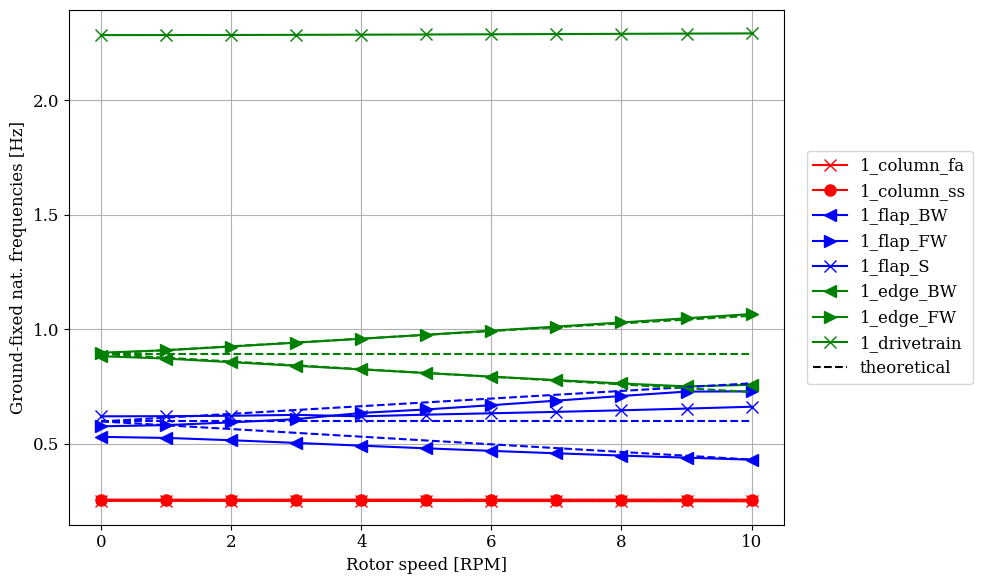

In [13]:

TURBINE_NAME = 'remodel'
CMB_PATH = 'remodel/remodel_structural_campbell.cmb'
#MODE_NAMES = ['Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6',
#              'Mode 7', 'Mode 8', 'Mode 9']
MODE_NAMES = ['1_column_fa', '1_column_ss', '1_flap_BW', '1_flap_FW', '1_flap_S',
              '1_edge_BW', '1_edge_FW', '1_drivetrain']
DT_MODENUM = 12  # what mode number in HAWCStab2 is the drivetrain mode?
# define turbine natural frequency? blade-only natural frequencies?

# load campbell diagram
omega, dfreqs, _ = load_cmb(CMB_PATH, cmb_type='structural')
omega_rpm = omega * 30 / np.pi  # from rad/s to RPM
NNODES = len(omega_rpm)
nmodes = dfreqs.shape[1]

# swap modes 5 and 6 after 3 RPM. hawcstab2 mixed them up at the crossing.
# note that numpy index is off by 2 because of python + skipping rigid-body mode.
SWAP_RPM = 3
dfreq_mode5 = dfreqs[omega_rpm > SWAP_RPM, 3]
dfreqs[omega_rpm > SWAP_RPM, 3] = dfreqs[omega_rpm > SWAP_RPM, 4]
dfreqs[omega_rpm > SWAP_RPM, 4] = dfreq_mode5


# single blade
CMB_blade_PATH = 'remodel/remodel_structural_campbell_blade.cmb'
omega_b, dfreqs_b, _ = load_cmb(CMB_blade_PATH, cmb_type='structural')
tower = (dfreqs[0, 0] + dfreqs[0, 1])/2

blade_1flap =  dfreqs_b[0, 0]
blade_1edge =  dfreqs_b[0, 1]
print(blade_1flap)

# theoretical values
th_1flap_S = np.ones(NNODES)*blade_1flap
th_1flap_BW = th_1flap_S - omega/(2*np.pi)
th_1flap_FW = th_1flap_S + omega/(2*np.pi)

th_1edge_S = np.ones(NNODES)*blade_1edge
th_1edge_BW = th_1edge_S - omega/(2*np.pi)
th_1edge_FW = th_1edge_S + omega/(2*np.pi)

th_tower = np.ones(NNODES)*tower

P1 = omega/(2*np.pi)
P3 = P1*3
P6 = P1*6


# harmonic data
P_harm_path = "remodel/data/remodel_flex.opt"
P_harm_data = load_oper(P_harm_path)
P_want = [1,3,6]


NMODES = len(MODE_NAMES)


fig, ax = plt.subplots(figsize=(10, 6))
# plot tower
ax.plot(omega_rpm, dfreqs[:, 0], marker='x', c='r', label=MODE_NAMES[0], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 1], marker='o', c='r', label=MODE_NAMES[1], markersize=8)
# plot 1 edge
ax.plot(omega_rpm, dfreqs[:, 2], marker='<', c='b', label=MODE_NAMES[2], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 3], marker='>', c='b', label=MODE_NAMES[3], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 4], marker='x', c='b', label=MODE_NAMES[4], markersize=8)

ax.plot(omega_rpm, dfreqs[:, 5], marker='<', c='g', label=MODE_NAMES[5], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 6], marker='>', c='g', label=MODE_NAMES[6], markersize=8)
ax.plot(omega_rpm, dfreqs[:, DT_MODENUM], marker='x', c='g', label=MODE_NAMES[7], markersize=8)

# plot theoretical
ax.plot([], [], linestyle='--', color='k', label='theoretical')
ax.plot(omega_rpm, th_1flap_S,  c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_BW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_FW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1edge_S,  c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_BW, c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_FW, c='g', linestyle='--')
ax.plot(omega_rpm, th_tower, c='r', linestyle='--')


#for P in P_want:
#    harmonic_line=ax.plot(P_harm_data["rotor_speed_rpm"],P*(P_harm_data["rotor_speed_rpm"]*(1/60)), color="black")


# prettify
ax.set(xlabel='Rotor speed [RPM]', ylabel='Ground-fixed nat. frequencies [Hz]')
ax.grid()
ax.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

# add figure title and scale nicely
#fig.suptitle(f'Structural Campbell diagram for {TURBINE_NAME}')
fig.tight_layout()
#plt.savefig('plots/01_structural_campbell.pdf', format='pdf')
plt.show()


0.596468


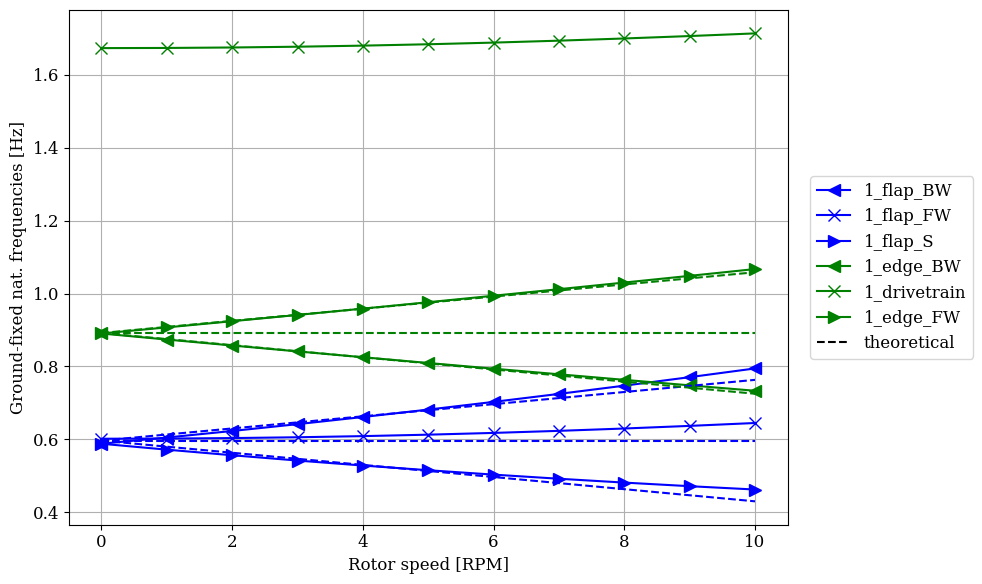

In [15]:
# no tower flexibility

CMB_PATH = 'remodel/remodel_structural_campbell_no_tower.cmb'
#MODE_NAMES = ['Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6',
#              'Mode 7', 'Mode 8', 'Mode 9']
MODE_NAMES = ['1_flap_BW', '1_flap_FW', '1_flap_S',
              '1_edge_BW', '1_edge_FW', '1_drivetrain']
DT_MODENUM = 7  # what mode number in HAWCStab2 is the drivetrain mode?
# define turbine natural frequency? blade-only natural frequencies?

# load campbell diagram
omega, dfreqs, _ = load_cmb(CMB_PATH, cmb_type='structural')
omega_rpm = omega * 30 / np.pi  # from rad/s to RPM
NNODES = len(omega_rpm)

# single blade
CMB_blade_PATH = 'remodel/remodel_structural_campbell_blade.cmb'
omega_b, dfreqs_b, _ = load_cmb(CMB_blade_PATH, cmb_type='structural')

blade_1flap =  dfreqs_b[0, 0]
blade_1edge =  dfreqs_b[0, 1]
print(blade_1flap)

# theoretical values
th_1flap_S = np.ones(NNODES)*blade_1flap
th_1flap_BW = th_1flap_S - omega/(2*np.pi)
th_1flap_FW = th_1flap_S + omega/(2*np.pi)

th_1edge_S = np.ones(NNODES)*blade_1edge
th_1edge_BW = th_1edge_S - omega/(2*np.pi)
th_1edge_FW = th_1edge_S + omega/(2*np.pi)

P1 = omega/(2*np.pi)
P3 = P1*3
P6 = P1*6

NMODES = len(MODE_NAMES)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega_rpm, dfreqs[:, 1], marker='<', c='b', label=MODE_NAMES[0], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 2], marker='x', c='b', label=MODE_NAMES[1], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 0], marker='>', c='b', label=MODE_NAMES[2], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 3], marker='<', c='g', label=MODE_NAMES[3], markersize=8)
ax.plot(omega_rpm, dfreqs[:, DT_MODENUM], marker='x', c='g', label=MODE_NAMES[5], markersize=8)
ax.plot(omega_rpm, dfreqs[:, 4], marker='>', c='g', label=MODE_NAMES[4], markersize=8)

# plot theoretical
ax.plot([], [], linestyle='--', color='k', label='theoretical')
ax.plot(omega_rpm, th_1flap_S,  c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_BW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1flap_FW, c='b', linestyle='--')
ax.plot(omega_rpm, th_1edge_S,  c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_BW, c='g', linestyle='--')
ax.plot(omega_rpm, th_1edge_FW, c='g', linestyle='--')
#ax.plot(omega_rpm, P1, c='k', linestyle='-', label='1P', zorder=1)
#ax.plot(omega_rpm, P3, c='k', linestyle='-', label='3P', zorder=1)
#ax.plot(omega_rpm, P6, c='k', linestyle='-', label='6P', zorder=1)


# prettify
ax.set(xlabel='Rotor speed [RPM]', ylabel='Ground-fixed nat. frequencies [Hz]')
ax.grid()
ax.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

# add figure title and scale nicely
#fig.suptitle(f'Structural Campbell diagram for {TURBINE_NAME}')
fig.tight_layout()
#plt.savefig('plots/01_structural_campbell_no_tower.pdf', format='pdf')
plt.show()


In [17]:
# Path to the .amp file
amp_path = 'remodel/remodel_structural_amp.amp'
amp_df = load_amp(amp_path)

print(amp_df.columns)
amp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')
#amp_df = amp_df.iloc[:, :-29]


wsp = amp_df['Wind speed'][1]
mode_names = [f'Mode {i}' for i in range(1, 12)]
wsp_1 = 0.1  # choose a wind speed
fig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')
#plt.savefig('plots/01_amplitude.pdf', format='pdf')
plt.show()

Index(['Rotor speed', 'TWR x [m]', 'phase [deg]', 'TWR y [m]', 'phase [deg]',
       'TWR yaw [rad]', 'phase [deg]', 'SFT x [m]', 'phase [deg]', 'SFT y [m]',
       ...
       'BW flap [m]', 'phase [deg]', 'FW flap [m]', 'phase [deg]',
       'Sym tors [rad]', 'phase [deg]', 'BW tors [rad]', 'phase [deg]',
       'FW tors [rad]', 'phase [deg]'],
      dtype='object', length=421)


AssertionError: 

In [16]:
# Path to the .amp file
amp_path = 'remodel/remodel_structural_amp_no_tower.amp'
amp_df = load_amp(amp_path)

print(amp_df.columns)
amp_df.columns = amp_df.columns.to_series().replace('Rotor speed', 'Wind speed')
#amp_df = amp_df.iloc[:, :-29]


wsp = amp_df['Wind speed'][1]
mode_names = [f'Mode {i}' for i in range(1, 12)]
wsp_1 = 0.1  # choose a wind speed
fig, ax = plot_amp(amp_df, mode_names, wsp, title=f'DTU 10 MW structural modal amplitudes at {wsp*30 / np.pi:.1f} rpm')
#plt.savefig('plots/01_amplitude.pdf', format='pdf')
plt.show()

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lacbox\io.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment='#', header=None)


FileNotFoundError: [Errno 2] No such file or directory: 'remodel/remodel_structural_amp_no_tower.amp'

## AEROELASTIC CAMPBELL

In [ ]:
# aeroelastic campbell

cmb_path = "remodel/hawcstab2_elastic_campbell.cmb"
cmb_type = "aeroelastic"

# Load the data
wsp, dfreqs, zetas = load_cmb(cmb_path, cmb_type)  # wind speed, damped natural freqs, and damping values

# print the shape
# dfreqs.shape  # n_wsp x n_modes

# extract data from HAWC result
P_harm_path = "remodel/data/Group1_camp_diagram.opt"
P_harm_data = load_oper(P_harm_path)


nmodes = dfreqs.shape[1]  # get number of modes

P_want = [1,3,6]
print(f"{P_want[0]}P, {P_want[1]}P, {P_want[2]}P")
mode_names = ["Tower base FA", "Tower base SS", "1st BW flap", "1st FW flap", "1st SYM flap", "1st BW edge", "1st FW edge", "2nd BW flap", "2nd FW flap", "2nd SYM flap"
              , "1st SYM edge","1P, 3P, 6P"]
mode_color = ["blue","blue","orange","orange","orange","green","green","red","red","red","green"]
mode_marker = ["|","x","<",">","o","<",">","<",">","o","o"]
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))


# left plot: damped nat freqs in ground-fixed frame

for k in range (11):
    axs[0].plot(wsp, dfreqs[:,k], color=mode_color[k], marker=mode_marker[k])#, label=mode_names[k])

for P in P_want:
    harmonic_line=axs[0].plot(P_harm_data["ws_ms"],P*(P_harm_data["rotor_speed_rpm"]*(1/60)), color="black")

axs[0].set(xlabel='Wind speed [m/s]', ylabel='Damped nat. frequencies [Hz]')
axs[0].grid()

# right plot: percent criticl damping
for k in range (11):
    lines = axs[1].plot(wsp, zetas[:,k], color=mode_color[k], marker=mode_marker[k])
axs[1].set(xlabel='Wind speed [m/s]', ylabel='Modal damping [% critical]')
axs[1].grid()

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)

lines=lines.append(harmonic_line)

fig.tight_layout(rect=[-0.2, -0.5, 1.2, 0.9])
fig.legend(loc='outside upper center', handles=lines, labels=mode_names, ncols=6)
#fig.tight_layout()
#fig.savefig(f'02_aeroelastic.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [ ]:
# Path to the .amp file
amp_path = 'aero_dofs_new_amp.amp'

# Load the modal amplitudes
amp_df = load_amp(amp_path)

print(amp_df.index)
amp_df.head()

wsp_1 = 17  # choose a wind speed

fig, ax = plot_amp(amp_df, mode_names[:-1], wsp_1, title=f'DTU 10 MW structural modal amplitudes at {wsp_1:.1f} m/s')
